In [155]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random
import re
import utilities as ut
import modularised_utils as mut
import networkx as nx

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

In [350]:
experiment = 'lilucas'
setting    = 'empirical'

if setting == 'gaussian':
    path = f"data/{experiment}/results"

elif setting == 'empirical':
    path = f"data/{experiment}/results_empirical"

saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
LLmodel       = all_data['LLmodel']
HLmodel       = all_data['HLmodel']
ll_graph      = all_data['LLmodel']['graph']
hl_graph      = all_data['HLmodel']['graph']
T_matrix_gt   = all_data['abstraction_data']['T']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'lilucas'.


In [351]:
# Load dictionaries containing the results for each optimization method
if setting == 'gaussian':
    diroca_results = joblib.load(f"{path}/diroca_cv_results.pkl")
    gradca_results = joblib.load(f"{path}/gradca_cv_results.pkl")
    baryca_results = joblib.load(f"{path}/baryca_cv_results.pkl")

elif setting == 'empirical':
    diroca_results = joblib.load(f"{path}/diroca_cv_results_empirical.pkl")
    gradca_results = joblib.load(f"{path}/gradca_cv_results_empirical.pkl")
    baryca_results = joblib.load(f"{path}/baryca_cv_results_empirical.pkl")
    abslingam_results = joblib.load(f"{path}/abslingam_cv_results_empirical.pkl")

results_to_evaluate = {}

if setting == 'empirical':
    if abslingam_results:
        first_fold_key = list(abslingam_results.keys())[0]
        for style in abslingam_results[first_fold_key].keys():
            method_name = f"Abs-LiNGAM ({style})"
            new_abslingam_dict = {}
            for fold_key, fold_results in abslingam_results.items():
                if style in fold_results:
                    new_abslingam_dict[fold_key] = {style: fold_results[style]}
            results_to_evaluate[method_name] = new_abslingam_dict
    
    def create_diroca_label(run_id):
        """Parses a run_id and creates a simplified label if epsilon and delta are equal."""
        # Use regular expression to find numbers for epsilon and delta
        matches = re.findall(r'(\d+\.?\d*)', run_id)
        if len(matches) == 2:
            eps, delta = matches
            # If they are the same, use the simplified format
            if eps == delta:
                # Handle integer conversion for clean labels like '1' instead of '1.0'
                val = int(float(eps)) if float(eps).is_integer() else float(eps)
                return f"DIROCA (eps_delta_{val})"
        # Otherwise, or if parsing fails, use the full original name
        return f"DIROCA ({run_id})"

    # Unpack each DIROCA hyperparameter run with the new, clean label
    if diroca_results:
        first_fold_key = list(diroca_results.keys())[0]
        for run_id in diroca_results[first_fold_key].keys():
            method_name = create_diroca_label(run_id) # Use the new helper to create the name
            new_diroca_dict = {}
            for fold_key, fold_results in diroca_results.items():
                if run_id in fold_results:
                    new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
            results_to_evaluate[method_name] = new_diroca_dict

    results_to_evaluate['GradCA'] = gradca_results
    results_to_evaluate['BARYCA'] = baryca_results

elif setting == 'gaussian':
    results_to_evaluate['GradCA'] = gradca_results
    results_to_evaluate['BARYCA'] = baryca_results

    if diroca_results:
        first_fold_key = list(diroca_results.keys())[0]
        diroca_run_ids = list(diroca_results[first_fold_key].keys())

        # create a separate entry for each DIROCA run
        for run_id in diroca_run_ids:
            method_name = f"DIROCA ({run_id})"
            
            new_diroca_dict = {}
            for fold_key, fold_results in diroca_results.items():
                # For each fold grab the data for the current run_id
                if run_id in fold_results:
                    new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
            
            results_to_evaluate[method_name] = new_diroca_dict

label_map_gaussian = {
                        'DIROCA (eps_delta_0.111)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA'
                    }

label_map_empirical = {
                        'DIROCA (eps_0.328_delta_0.107)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA',
                        'Abs-LiNGAM (Perfect)': 'Abslin_p',
                        'Abs-LiNGAM (Noisy)': 'Abslin_n'
                    }

if setting == 'empirical':
    results_to_evaluate = {label_map_empirical.get(key, key): value for key, value in results_to_evaluate.items()}

elif setting == 'gaussian':
    results_to_evaluate = {label_map_gaussian.get(key, key): value for key, value in results_to_evaluate.items()}

print("\nMethods available for evaluation:")
for key in results_to_evaluate.keys():
    print(f"  - {key}")


Methods available for evaluation:
  - Abslin_p
  - Abslin_n
  - DiRoCA_star
  - DIROCA_1
  - DIROCA_2
  - DIROCA_4
  - DIROCA_8
  - GradCA
  - BARYCA


In [352]:
def apply_structural_contamination_flexible(
    linear_data,
    graph,
    coeffs,
    noise,
    strength,
    scaled=True,
    nonlinear_func=np.sin,
    reuse=False,
    scm_instance=None
):
    """
    Applies structural contamination to SCM data with exact linear simulation.
    The nonlinear function is applied to true parent values from SCM output.

    Args:
        linear_data (np.ndarray): Clean data (used only if reuse=True).
        graph (CausalBayesianNetwork): SCM DAG.
        coeffs (dict): Edge weight dictionary.
        noise (np.ndarray): Exogenous noise (n_samples x dim).
        strength (float): Contamination level.
        scaled (bool): Interpolate vs add mode.
        nonlinear_func (callable): Nonlinear transformation on parent values.
        reuse (bool): If True, reuse `linear_data`; else simulate using `scm_instance`.
        scm_instance (LinearAddSCM): Required if reuse=False.

    Returns:
        np.ndarray: Contaminated data (n_samples x dim)
    """
    if reuse:
        linear_part = linear_data.copy()
    else:
        if scm_instance is None:
            raise ValueError("You must provide `scm_instance` when reuse=False.")
        linear_part = scm_instance.simulate(noise)

    #n_samples, dim = linear_part.shape
    topo_order = list(nx.topological_sort(graph))
    var_index = {var: idx for idx, var in enumerate(topo_order)}
    nonlinear_part = np.zeros_like(linear_part)

    # Compute nonlinear effect using *true parent values from linear SCM output*
    for var in topo_order:
        var_idx = var_index[var]
        parents = list(graph.predecessors(var))

        if not parents:
            continue
        else:
            parent_indices = [var_index[p] for p in parents]
            parent_vals = linear_part[:, parent_indices] 
            nonlinear_effect = nonlinear_func(parent_vals).sum(axis=1)

            nonlinear_part[:, var_idx] = nonlinear_effect  # unscaled, will combine later

    if scaled:
        contaminated = (1 - strength) * linear_part + strength * nonlinear_part
    else:
        contaminated = linear_part + strength * nonlinear_part

    return contaminated


In [353]:
def multi_piece_relu(x, num_pieces=2):
    """
    A piecewise function with `num_pieces` linear segments.
    Each piece is defined over an interval of the input domain.
    """
    x = np.asarray(x)
    output = np.zeros_like(x)
    bins = np.linspace(-1, 1, num_pieces + 1)  # Split domain into equal parts

    for i in range(num_pieces):
        left = bins[i]
        right = bins[i + 1]
        # Define the slope for this piece (can be arbitrary)
        slope = 1.0 + i
        # Apply linear function in the current bin
        mask = (x >= left) & (x < right)
        output[mask] = slope * (x[mask] - left)
    
    return output


def make_piecewise_func(strength):
    return lambda x: multi_piece_relu(x, num_pieces=int(strength))


In [354]:
def relu_squared(x):
    return np.maximum(0, x)**2

def leaky_relu(x, alpha=0.1):
    return np.where(x > 0, x, alpha * x)

def abs_shift(x):
    return np.abs(x - 1.0)

def relu(x):
    return np.maximum(x, 0)

def piecewise_relu(x):
    return np.where(x > 1, x**2, np.maximum(0, x - 0.5))

def tanh(x):
    return np.tanh(x)

def exp(x):
    return np.exp(x)

def sin(x):
    return np.sin(x)

def square(x):
    return x**2

In [355]:
contamination_strengths = np.linspace(0, 1.0, 5)
num_trials = 1  # low variance
nonlinear_func = square
scaled = True
reuse = False


In [356]:
def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
    """
    Calculates the abstraction error for a given T matrix on a test set.
    Estimates Gaussian parameters from LL and HL data, transforms LL with T,
    and computes the 2-Wasserstein distance to the HL distribution.
    """
    mu_L_test    = np.mean(Dll_test, axis=0)
    Sigma_L_test = np.cov(Dll_test, rowvar=False)

    mu_H_test    = np.mean(Dhl_test, axis=0)
    Sigma_H_test = np.cov(Dhl_test, rowvar=False)

    mu_V_predicted    = mu_L_test @ T_matrix.T
    Sigma_V_predicted = T_matrix @ Sigma_L_test @ T_matrix.T

    # Add a small ridge for numerical stability
    eps = 1e-8
    Sigma_V_predicted += np.eye(Sigma_V_predicted.shape[0]) * eps
    Sigma_H_test      += np.eye(Sigma_H_test.shape[0]) * eps

    try:
        wasserstein_dist = np.sqrt(mut.compute_wasserstein(
            mu_V_predicted, Sigma_V_predicted,
            mu_H_test, Sigma_H_test
        ))
    except Exception as e:
        print(f"  - Warning: Could not compute Wasserstein distance. Error: {e}. Returning NaN.")
        return np.nan

    return wasserstein_dist


In [357]:
f_spec_records = []

for strength in tqdm(contamination_strengths, desc="Contamination Strength"):
    for trial in range(num_trials):
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict.get(f'fold_{i}', {})
                for run_key, run_data in fold_results.items():
                    T_learned = run_data['T_matrix']
                    test_indices = run_data['test_indices']

                    errors_per_intervention = []

                    for iota in I_ll_relevant:
                        # Prepare inputs
                        Dll_clean = Dll_samples[iota][test_indices]
                        Dhl_clean = Dhl_samples[omega[iota]][test_indices]

                        noise_ll = LLmodel['noise'][iota][test_indices]
                        noise_hl = HLmodel['noise'][omega[iota]][test_indices]

                        scm_ll = LLmodel['scm_instances'][iota]
                        scm_hl = HLmodel['scm_instances'][omega[iota]]

                        # Apply contamination (now supports faithful recomputation for s=0)
                        Dll_cont = apply_structural_contamination_flexible(
                            linear_data=Dll_clean,
                            graph=ll_graph,
                            coeffs=LLmodel['coeffs'],
                            noise=noise_ll,
                            strength=strength,
                            scaled=scaled,
                            nonlinear_func=nonlinear_func,
                            reuse=reuse,
                            scm_instance=scm_ll
                        )

                        Dhl_cont = apply_structural_contamination_flexible(
                            linear_data=Dhl_clean,
                            graph=hl_graph,
                            coeffs=HLmodel['coeffs'],
                            noise=noise_hl,
                            strength=strength,
                            scaled=scaled,
                            nonlinear_func=nonlinear_func,
                            reuse=reuse,
                            scm_instance=scm_hl
                        )

                        # Compute abstraction error
                        if setting == 'gaussian':
                            error = calculate_abstraction_error(T_learned, Dll_cont, Dhl_cont)
                        elif setting == 'empirical':
                            error = ut.calculate_empirical_error(T_learned, Dll_cont, Dhl_cont)
                        else:
                            raise ValueError(f"Unknown setting: {setting}")

                        if not np.isnan(error):
                            errors_per_intervention.append(error)

                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    f_spec_records.append({
                        'method': method_name,
                        'contamination': strength,
                        'trial': trial,
                        'fold': i,
                        'error': avg_error
                    })


Contamination Strength:   0%|          | 0/5 [00:00<?, ?it/s]

Contamination Strength: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 684.1733 ± 222.7545
DIROCA_4                            | 684.2127 ± 222.7144
DIROCA_2                            | 686.6899 ± 227.4670
DIROCA_1                            | 734.9603 ± 265.4905
Abslin_n                            | 752.4965 ± 267.2440
Abslin_p                            | 913.7738 ± 316.3040
GradCA                              | 1108.5009 ± 481.2622
DiRoCA_star                         | 1485.6911 ± 672.2956
BARYCA                              | 1653.1326 ± 760.1080


/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_22716/779775597.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(


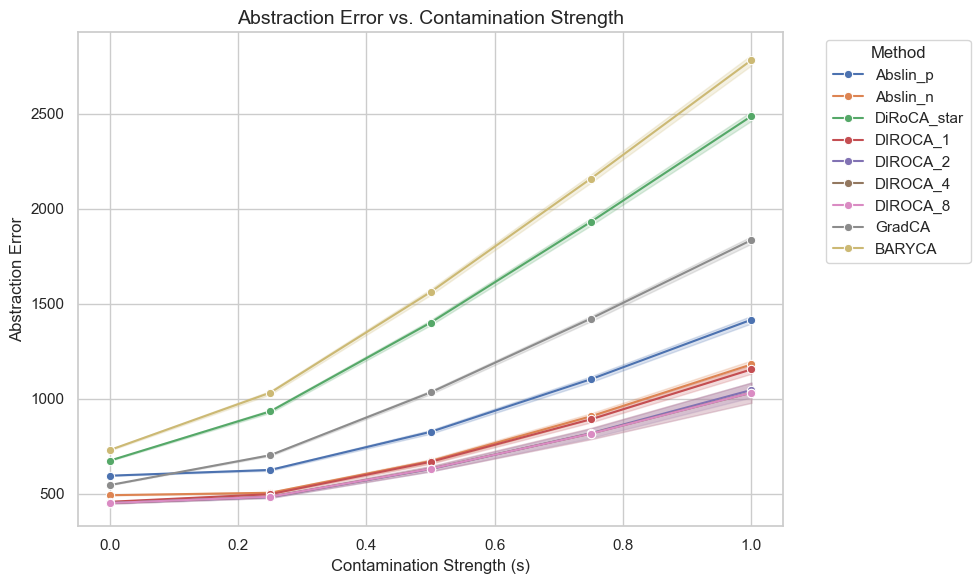

In [358]:
# Compile results into a DataFrame
f_spec_df = pd.DataFrame(f_spec_records)

print("\n--- F-Misspecification Evaluation Complete ---")
print("="*65)
print("Overall Performance (Averaged Across All Nonlinearity Strengths)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean ± Std'}")
print("="*65)

summary = f_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std']  # You can uncomment next line for CI
# summary['sem'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = summary['sem']  # or 1.96 * sem

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")

# Set plot style
sns.set(style="whitegrid")

# Plot abstraction error vs. contamination strength
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=f_spec_df,
    x="contamination",
    y="error",
    hue="method",
    estimator="mean",
    ci="sd",
    marker="o"
)

plt.title("Abstraction Error vs. Contamination Strength", fontsize=14)
plt.xlabel("Contamination Strength (s)", fontsize=12)
plt.ylabel("Abstraction Error", fontsize=12)
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


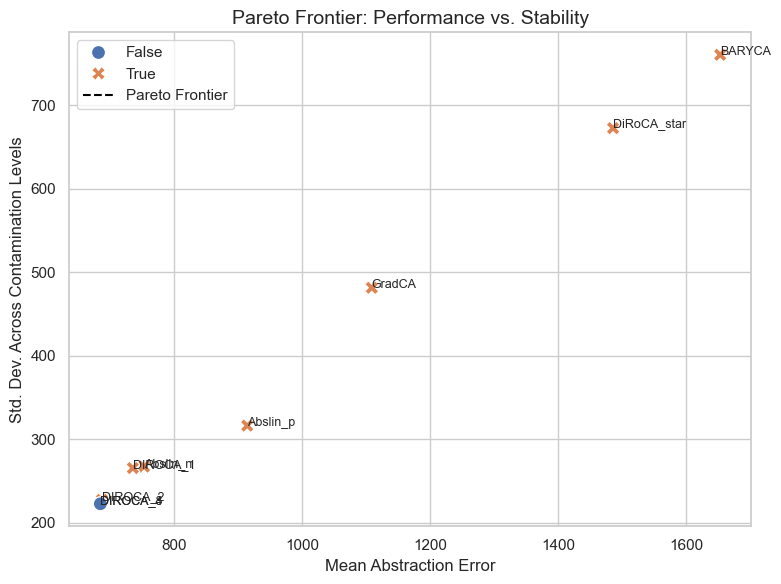

In [359]:
mean_var_df = f_spec_df.groupby('method')['error'].agg(['mean', 'std']).reset_index()
def is_dominated(row, others):
    return any(
        (other['mean'] <= row['mean']) and
        (other['std'] <= row['std']) and
        ((other['mean'], other['std']) != (row['mean'], row['std']))
        for _, other in others.iterrows()
    )

mean_var_df['dominated'] = mean_var_df.apply(lambda row: is_dominated(row, mean_var_df), axis=1)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mean_var_df, x='mean', y='std', hue='dominated', style='dominated', s=100)

for _, row in mean_var_df.iterrows():
    plt.text(row['mean'] + 0.002, row['std'] + 0.002, row['method'], fontsize=9)

# Highlight Pareto frontier
frontier = mean_var_df[~mean_var_df['dominated']].sort_values('mean')
plt.plot(frontier['mean'], frontier['std'], linestyle='--', color='black', label='Pareto Frontier')

plt.xlabel('Mean Abstraction Error', fontsize=12)
plt.ylabel('Std. Dev. Across Contamination Levels', fontsize=12)
plt.title('Pareto Frontier: Performance vs. Stability', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


# Final for real

In [6]:
def apply_structural_contamination(
    linear_data,
    graph,
    coeffs,
    noise,
    strength,
    scaled=True,
    nonlinear_func=np.sin,
    reuse=False
):
    """
    Applies structural contamination to SCM data with flexible reuse strategy.

    Args:
        linear_data (np.ndarray): Original SCM output (already includes noise).
        graph (CausalBayesianNetwork): DAG structure.
        coeffs (dict): Edge weights {(parent, child): weight}.
        noise (np.ndarray): Exogenous noise (same shape as linear_data).
        strength (float): Contamination strength s ∈ [0, 1] (can be >1 if unscaled).
        scaled (bool): Whether to interpolate (scaled=True) or add (scaled=False).
        nonlinear_func (callable): Nonlinear function applied to parent values.
        reuse (bool): 
            - If True, always build on `linear_data` (reuse mode).
            - If False, only use `linear_data` when strength == 0 (recompute mode).

    Returns:
        np.ndarray: Contaminated data (n_samples x dim).
    """
    n_samples, dim = linear_data.shape
    topo_order = list(nx.topological_sort(graph))
    var_index = {var: idx for idx, var in enumerate(topo_order)}

    if strength == 0:
        return linear_data.copy()

    if reuse:
        contaminated = np.zeros_like(linear_data)

        for var in topo_order:
            var_idx = var_index[var]
            parents = list(graph.predecessors(var))

            linear_part = linear_data[:, var_idx]

            if not parents:
                nonlinear_part = np.zeros(n_samples)
            else:
                parent_indices = [var_index[p] for p in parents]
                parent_vals = contaminated[:, parent_indices]
                nonlinear_part = nonlinear_func(parent_vals).sum(axis=1)

            if scaled:
                contaminated[:, var_idx] = (1 - strength) * linear_part + strength * nonlinear_part
            else:
                contaminated[:, var_idx] = linear_part + strength * nonlinear_part

        return contaminated

    else:
        # Recompute using SCM structure
        contaminated = np.zeros_like(noise)

        for var in topo_order:
            var_idx = var_index[var]
            parents = list(graph.predecessors(var))

            if not parents:
                linear_part = np.zeros(n_samples)
                nonlinear_part = np.zeros(n_samples)
            else:
                parent_indices = [var_index[p] for p in parents]
                parent_vals = contaminated[:, parent_indices]
                weights = np.array([coeffs.get((p, var), 0.0) for p in parents])
                linear_part = parent_vals @ weights
                nonlinear_part = nonlinear_func(parent_vals).sum(axis=1)

            if scaled:
                blended = (1 - strength) * linear_part + strength * nonlinear_part
            else:
                blended = linear_part + strength * nonlinear_part

            contaminated[:, var_idx] = blended + noise[:, var_idx]

        return contaminated


In [ ]:
contamination_strengths = np.linspace(0, 10.0, 10)  
num_trials = 1
nonlinear_func = np.sin  # or np.tanh, np.exp, etc.
scaled = False            # whether to blend or add nonlinearity

if scaled == True: print('check s upper bound!')
reuse = False     # 'reuse' or 'recompute'

In [ ]:
f_spec_records = []

for strength in tqdm(contamination_strengths, desc="Contamination Strength"):
    for trial in range(num_trials):
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict.get(f'fold_{i}', {})
                for run_key, run_data in fold_results.items():
                    T_learned = run_data['T_matrix']
                    test_indices = run_data['test_indices']

                    errors_per_intervention = []

                    for iota in I_ll_relevant:
                        # Prepare inputs
                        Dll_clean = Dll_samples[iota][test_indices]
                        Dhl_clean = Dhl_samples[omega[iota]][test_indices]

                        noise_ll = LLmodel['noise'][iota][test_indices]
                        noise_hl = HLmodel['noise'][omega[iota]][test_indices]

                        # Apply contamination based on current strategy
                        Dll_cont = apply_structural_contamination(
                            linear_data=Dll_clean,
                            graph=ll_graph,
                            coeffs=LLmodel['coeffs'],
                            noise=noise_ll,
                            strength=strength,
                            scaled=scaled,
                            nonlinear_func=nonlinear_func,
                            reuse=reuse
                        )

                        Dhl_cont = apply_structural_contamination(
                            linear_data=Dhl_clean,
                            graph=hl_graph,
                            coeffs=HLmodel['coeffs'],
                            noise=noise_hl,
                            strength=strength,
                            scaled=scaled,
                            nonlinear_func=nonlinear_func,
                            reuse=reuse
                        )

                        if setting == 'gaussian':
                            error = ut.calculate_abstraction_error(T_learned, Dll_cont, Dhl_cont)
                        elif setting == 'empirical':
                            error = ut.calculate_empirical_error(T_learned, Dll_cont, Dhl_cont)
                        else:
                            raise ValueError(f"Unknown setting: {setting}")

                        if not np.isnan(error):
                            errors_per_intervention.append(error)

                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    f_spec_records.append({
                        'method': method_name,
                        'contamination': strength,
                        'trial': trial,
                        'fold': i,
                        'error': avg_error
                    })


Contamination Strength: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]



--- F-Misspecification Evaluation Complete ---
Overall Performance (Averaged Across All Nonlinearity Strengths)
Method/Run                          | Mean ± Std
DIROCA_8                            | 168.7098 ± 90.1786
DIROCA_4                            | 171.9036 ± 88.7157
DIROCA_2                            | 178.3750 ± 102.7497
GradCA                              | 184.9190 ± 99.1399
DIROCA_1                            | 189.6499 ± 99.2131
DIROCA (eps_0.107_delta_0.035)      | 316.7626 ± 162.6430
BARYCA                              | 323.0680 ± 174.6732
Abslin_n                            | 351.5392 ± 194.7212
Abslin_p                            | 352.4931 ± 193.3222


/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_14509/779775597.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(


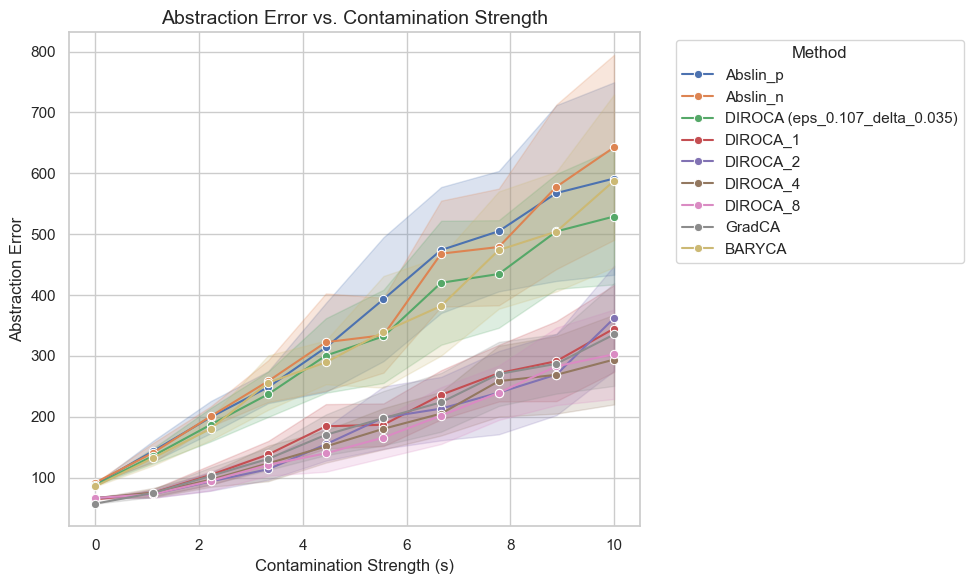

In [185]:
# Compile results into a DataFrame
f_spec_df = pd.DataFrame(f_spec_records)

print("\n--- F-Misspecification Evaluation Complete ---")
print("="*65)
print("Overall Performance (Averaged Across All Nonlinearity Strengths)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean ± Std'}")
print("="*65)

summary = f_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std']  # You can uncomment next line for CI
# summary['sem'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = summary['sem']  # or 1.96 * sem

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")

# Set plot style
sns.set(style="whitegrid")

# Plot abstraction error vs. contamination strength
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=f_spec_df,
    x="contamination",
    y="error",
    hue="method",
    estimator="mean",
    ci="sd",
    marker="o"
)

plt.title("Abstraction Error vs. Contamination Strength", fontsize=14)
plt.xlabel("Contamination Strength (s)", fontsize=12)
plt.ylabel("Abstraction Error", fontsize=12)
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
